In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torchvision



In [19]:
VGG = [32,32,'M',64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
class VGG_net(nn.Module):
    def __init__(self,in_channels=3,num_classes=10):
        super(VGG_net,self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG)
        
        self.fc_block = nn.Sequential(nn.Linear(512,512),
                                     nn.ReLU(),
                                     nn.Linear(512,num_classes))
        
        
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0],-1)
        
        x = self.fc_block(x)
        return x
        
    
    
    def create_conv_layers(self,architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x)==int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=(3,3),stride=(1,1),padding=(1,1)),nn.BatchNorm2d(x),nn.ReLU()]
                in_channels= x
                
            elif x =='M':
                layers += [nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))]
                
        return nn.Sequential(*layers)
                
            

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg = VGG_net(in_channels=3,num_classes=10)

In [22]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


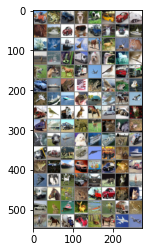

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [24]:
accuracy_list = []

def train(epoch,model):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        # send to device
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()
        output = model(data)
        
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
       
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
   
    with torch.no_grad():
        for data, target in testloader:

            data, target = data.to(device), target.to(device)

            output = model(data)
            #sum up batch loss 
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)

            correct += predicted.eq(target).sum().item()
        
        
        test_loss /= len(testloader.dataset)
        accuracy = 100.*correct/len(testloader.dataset)
        accuracy_list.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct,len(testloader.dataset),
            accuracy
        ))

    return accuracy,test_loss

In [29]:
vgg.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

PATH ='model.pt'

optimizer = optim.SGD(vgg.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
prev_test_accuracy =-1
for epoch in range(0,50):
    train(epoch,vgg)
    test_accuracy,test_loss=test(vgg)

    if test_accuracy >prev_test_accuracy:
        torch.save({
                'epoch': epoch,
                'model_state_dict': vgg.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
                }, PATH)
        print("weights from epoch {} has been saved ",epoch)
        prev_test_accuracy = test_accuracy

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.335475
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.937658
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.910997
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.927003

Test set: Average loss: 0.0178, Accuracy: 3112/10000 (31%)

weights from epoch {} has been saved  0
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.758333
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.568398
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.383845
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.482493

Test set: Average loss: 0.0146, Accuracy: 4270/10000 (43%)

weights from epoch {} has been saved  1
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.356206
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.301048
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.156004
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.058753

Test set: Average loss: 0.0107, Accuracy: 5999/10000 (60%)

weights from epoch {} has been saved  2
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.876317
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.945995
Train Epoch: 3 [2